Before Continuing:
First, enable the T4 GPU in Google Colab.

In the top menu, go to Runtime → Change Runtime Type.

Under Hardware Accelerator, select T4 GPU from the drop-down menu.

Click Save. Colab will automatically restart the session with the GPU enabled.

In [79]:
# =============================================================
# TP03 - Model Optimization and Deployment Readiness
# Facial Emotion Recognition (FER2013)
# =============================================================

import tensorflow as tf
# Enable memory growth BEFORE initializing any tensors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled before TF initialization")
    except RuntimeError as e:
        print(e)


Memory growth enabled before TF initialization


In [80]:
#Libraries and Configuration
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, glob
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [81]:
# =============================================================
# Optimized FER2013 Loading via KaggleHub
# =============================================================
import os
import kagglehub
import tensorflow as tf

# Download FER2013 dataset only if not already cached
print("Checking for FER2013 dataset...")
path = kagglehub.dataset_download("msambare/fer2013")
print("Dataset available at:", path)

# Directly reference dataset folders (no need to copy)
train_dir = os.path.join(path, "train")
val_dir   = os.path.join(path, "test")

print("Using dataset directly from KaggleHub cache.")
print("Dataset path in cache:", path)

print(f"Train dir: {train_dir}")
print(f"Val dir: {val_dir}")


⏳ Checking for FER2013 dataset...
Using Colab cache for faster access to the 'fer2013' dataset.
Dataset available at: /kaggle/input/fer2013
Using dataset directly from KaggleHub cache.
Dataset path in cache: /kaggle/input/fer2013
Train dir: /kaggle/input/fer2013/train
Val dir: /kaggle/input/fer2013/test


In [82]:
# --- Check GPU (useful in Colab) ---
!nvidia-smi

# --- Enable mixed precision (must be before model building) ---
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Sanity check
import tensorflow as tf
print("Compute dtype policy:", mixed_precision.global_policy())
print("TF version:", tf.__version__)


Wed Oct  8 17:23:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             27W /   70W |     782MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [83]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [84]:
# =============================================================
# Create image datasets for training and validation
# =============================================================

batch_size = 128
img_height, img_width = 48, 48
AUTOTUNE = tf.data.AUTOTUNE

# ✅ Usa las rutas confirmadas
train_dir = "/kaggle/input/fer2013/train"
val_dir   = "/kaggle/input/fer2013/test"

# ---- Carga de datos ----
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)


# =============================================================
# Normalize pixel values (0–1) and improve performance
# =============================================================
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    train_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

print("✅ Pipeline optimizado (batch=128, cache, prefetch) listo.")

# =============================================================
# Informative message about dataset split
# =============================================================
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()

train_ratio = train_batches / (train_batches + val_batches)
val_ratio = val_batches / (train_batches + val_batches)

print(f"\nDataset split confirmed based on FER2013 structure:")
print(f"   • Training Batch: {train_ratio * 100:.1f}% ({train_batches} batches)")
print(f"   • Validation Batch: {val_ratio * 100:.1f}% ({val_batches} batches)")
print("   (FER2013 dataset includes pre-defined train/test folders.)")

print("\nTrain batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("\nTraining and validation datasets ready for model input.")

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
✅ Pipeline optimizado (batch=128, cache, prefetch) listo.

Dataset split confirmed based on FER2013 structure:
   • Training Batch: 79.8% (225 batches)
   • Validation Batch: 20.2% (57 batches)
   (FER2013 dataset includes pre-defined train/test folders.)

Train batches: 225
Validation batches: 57

Training and validation datasets ready for model input.


In [85]:
# =============================================================
# Check class distribution
# =============================================================
# Get class names before applying cache and prefetch
class_names = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),  # Use img_height and img_width instead of img_size
    color_mode='grayscale',
    batch_size=batch_size,
    label_mode='int',   # compatible con sparse_categorical_crossentropy
    shuffle=True
).class_names
print("Classes:", class_names)

counts = {c: len(glob.glob(os.path.join(train_dir,c,'*'))) for c in class_names}
print("Image distribution (train):", counts)

import pandas as pd
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['# Images'])
counts_df

Found 28709 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Image distribution (train): {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


,# Images
angry,3995
disgust,436
fear,4097
happy,7215
neutral,4965
sad,4830
surprise,3171


In [86]:
# Build summary dictionary
import pandas as pd
import os
import glob

# Define variables needed for the summary
img_width, img_height = 48, 48 # Define img_width and img_height based on the dataset
num_classes = len(class_names) # class_names is defined in cell Tuo1NTfa87J9

# Calculate total images (sum of images in train and validation directories)
total_images = sum(len(glob.glob(os.path.join(train_dir, c, '*'))) for c in class_names) + \
               sum(len(glob.glob(os.path.join(val_dir, c, '*'))) for c in class_names) # train_dir and val_dir are defined in cell 0sqB4Nki4beR

# Calculate split ratio based on the number of files in train and validation directories
train_count = sum(len(glob.glob(os.path.join(train_dir, c, '*'))) for c in class_names)
val_count = sum(len(glob.glob(os.path.join(val_dir, c, '*'))) for c in class_names)
total_count = train_count + val_count
split_ratio = {
    'Training (%)': (train_count / total_count) * 100 if total_count > 0 else 0,
    'Validation/Testing (%)': (val_count / total_count) * 100 if total_count > 0 else 0
}


summary = {
    "Total Images": [total_images],
    "Image Resolution": [f"{img_width}x{img_height} pixels"],
    "Color Mode": ["Grayscale"],
    "Emotion Classes": [num_classes],
    "Train/Validation/Test Split": [f"{split_ratio['Training (%)']:.1f}% / {split_ratio['Validation/Testing (%)']:.1f}%"],
    "Imbalance Notice": ["‘Disgust’ class underrepresented"],
    "Average Pixels per Image": [img_height * img_width],
    "File Format": ["PNG"] # Assuming PNG based on common dataset formats, adjust if needed
}

summary_df = pd.DataFrame(summary)
print("Summary statistics for FER2013 dataset generated successfully.")
display(summary_df)

Summary statistics for FER2013 dataset generated successfully.


,Total Images,Image Resolution,Color Mode,Emotion Classes,Train/Validation/Test Split,Imbalance Notice,Average Pixels per Image,File Format
0,35887,48x48 pixels,Grayscale,7,80.0% / 20.0%,‘Disgust’ class underrepresented,2304,PNG


Dataset found at: /kaggle/input/fer2013/train
Classes detected: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


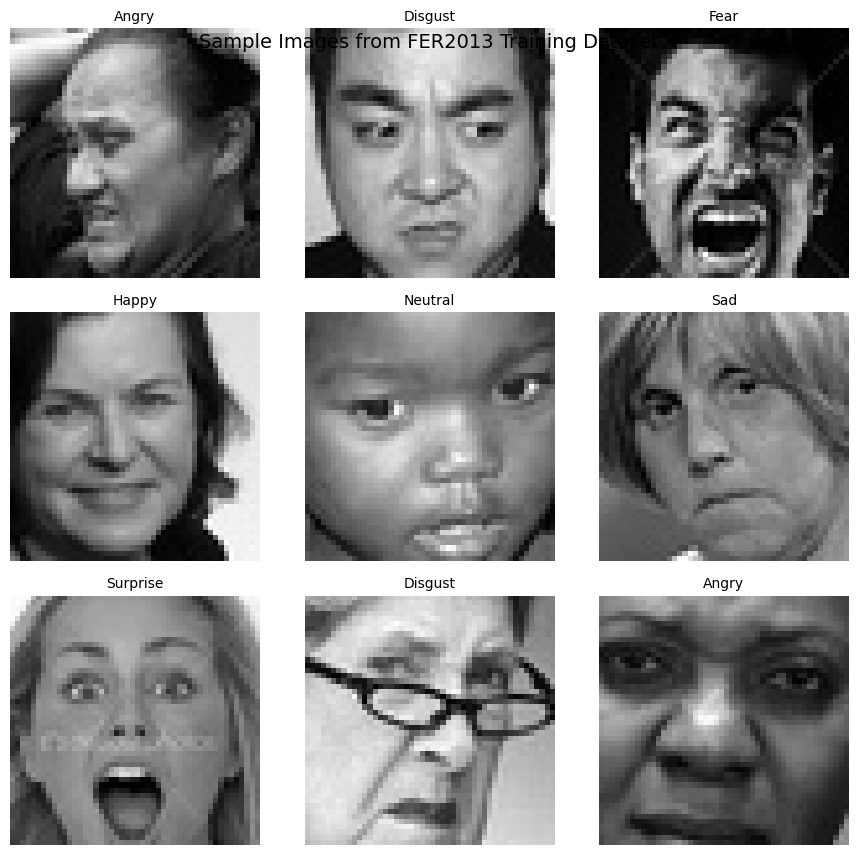

Displayed 9 sample images representing different emotion classes.


In [89]:
# =============================================================
# Visualize Sample Images from Each Emotion Class (Safe Version)
# =============================================================
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ensure consistent random results for reproducibility
random.seed(42)

# --- Step 1: Verify dataset availability ---
try:
    if not os.path.exists(train_dir):
        raise FileNotFoundError("'train_dir' not found. Please ensure the dataset was downloaded and assigned correctly.")
    else:
        print(f"Dataset found at: {train_dir}")
        print("Classes detected:", os.listdir(train_dir))
except NameError:
    raise NameError("Variable 'train_dir' is not defined. Please re-run the dataset loading cell first.")

# --- Step 2: Collect random images from each class ---
class_names = sorted(os.listdir(train_dir))
image_paths = []

# Collect one random image per class
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        img_file = random.choice(os.listdir(cls_path))
        img_path = os.path.join(cls_path, img_file)
        image_paths.append((cls, img_path))

# Add 2 extra random samples for a total of 9
for _ in range(2):
    cls = random.choice(class_names)
    cls_path = os.path.join(train_dir, cls)
    img_file = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_file)
    image_paths.append((cls, img_path))

# --- Step 3: Plot 3x3 grid of sample images ---
plt.figure(figsize=(9, 9))
for i, (cls, img_path) in enumerate(image_paths):
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(cls.capitalize(), fontsize=10)
    plt.axis("off")

plt.suptitle("Sample Images from FER2013 Training Dataset", fontsize=14, y=0.92)
plt.tight_layout()
plt.show()

print("Displayed 9 sample images representing different emotion classes.")


In [90]:
# =============================================================
# Build Optimized CNN Model for Facial Emotion Recognition
# =============================================================

from tensorflow import keras
from tensorflow.keras import layers, regularizers

# ---- Data Augmentation (GPU accelerated) ----
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# ---- Model Architecture ----
inputs = layers.Input(shape=(48, 48, 1))
x = data_augmentation(inputs)

# Convolutional Blocks
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

# Classification Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(
    128, activation=None, use_bias=False,
    kernel_regularizer=regularizers.l2(1e-5)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

# Salida — 7 clases (FER2013)
outputs = layers.Dense(7, activation="softmax", dtype="float32")(x)

# Build model
model = keras.Model(inputs, outputs, name="FER_CNN_Optimized")

# ---- Compile Model ----
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "FER_CNN_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 423,463 (1.62 MB)

 Trainable params: 422,247 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [91]:
# =============================================================
# Step 4 — Train, Evaluate, and Save FER2013 Optimized Model
# with Advanced Callbacks and Google Drive Integration
# =============================================================
import matplotlib.pyplot as plt
import json, datetime, os
from google.colab import drive
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
)

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Destination folder in Drive ---
save_dir = "/content/drive/MyDrive/FER2013_Models"
os.makedirs(save_dir, exist_ok=True)

# =============================================================
# Callback Setup
# =============================================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = os.path.join(save_dir, "best_model.keras")
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

class TrainingMonitor(Callback):
    def on_train_end(self, logs=None):
        if early_stopping.stopped_epoch > 0:
            print(f"\nTraining stopped early at epoch {early_stopping.stopped_epoch}.")
            print(f"Reason: No improvement in '{early_stopping.monitor}' "
                  f"for {early_stopping.patience} consecutive epochs.")
            print(f"Best Validation Accuracy: "
                  f"{max(self.model.history.history['val_accuracy']):.4f}")
            print(f"Best Validation Loss: "
                  f"{min(self.model.history.history['val_loss']):.4f}")
        else:
            print("\nTraining completed all scheduled epochs without early stopping.")

# =============================================================
# Training
# =============================================================
EPOCHS = 50
start_time = datetime.datetime.now()
print(f"Training started at {start_time.strftime('%H:%M:%S')}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping, checkpoint, reduce_lr, TrainingMonitor()]
)

end_time = datetime.datetime.now()
print(f"✅ Training finished at {end_time.strftime('%H:%M:%S')}")
print(f"🕒 Total training time: {end_time - start_time}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training started at 17:27:56
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1923 - loss: 2.1221
Epoch 1: val_loss improved from inf to 1.93728, saving model to /content/drive/MyDrive/FER2013_Models/best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.1924 - loss: 2.1218 - val_accuracy: 0.1718 - val_loss: 1.9373 - learning_rate: 1.0000e-04
Epoch 2/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2425 - loss: 1.9292
Epoch 2: val_loss improved from 1.93728 to 1.84858, saving model to /content/drive/MyDrive/FER2013_Models/best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2426 - loss: 1.9290 - val_accuracy: 0.2306 - val_loss: 1.8486 - learning_rate: 1.0000e-04
Epoch 3/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2723 - loss: 1.8495
Epoch 3: val_loss improved from 1.84858 to 1.6

In [ ]:
# =============================================================
# Load trained model (.keras)
# =============================================================
model_path = os.path.join(save_dir, "best_model.keras")  # or best_model_50epoch.keras
model = keras.models.load_model(model_path)
print(f"✅ Model loaded successfully from: {model_path}\n")

# --- Verify model structure ---
model.summary()

In [92]:
# --- Evaluate model performance ---
val_loss, val_acc = model.evaluate(val_ds, verbose=2)
print(f"\nValidation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

57/57 - 0s - 7ms/step - accuracy: 0.5411 - loss: 1.2070

Validation Accuracy: 54.11%
Validation Loss: 1.2070


Available keys in training history: ['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']


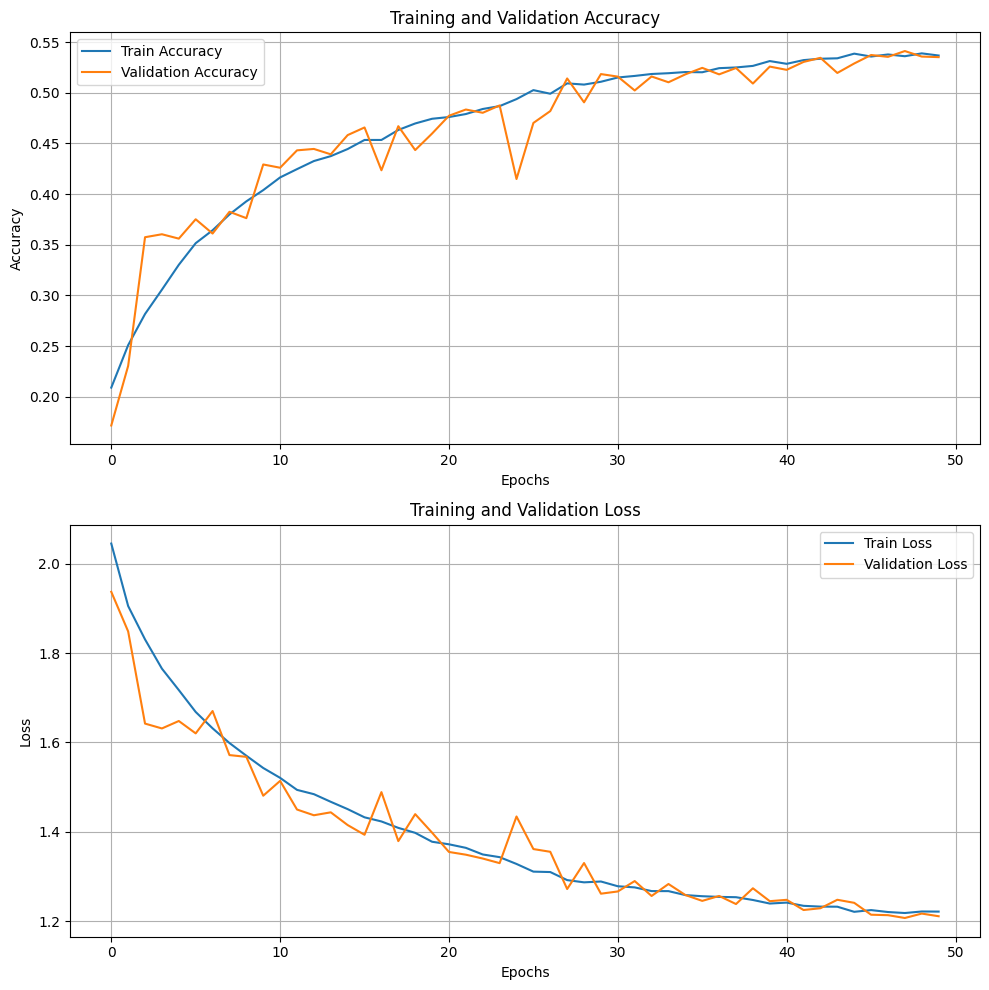

In [93]:
# =============================================================
# Model Evaluation and Visualization
# =============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf

# Detect if 'history' key is nested inside
if isinstance(history, dict) and 'history' in history:
    hist_data = history['history']
elif hasattr(history, 'history'):
    hist_data = history.history
else:
    hist_data = history  # fallback

# Print available keys for confirmation
print("Available keys in training history:", list(hist_data.keys()))

# Detect accuracy key automatically
acc_key = next((k for k in hist_data.keys() if 'acc' in k.lower()), None)
val_acc_key = next((k for k in hist_data.keys() if 'val_acc' in k.lower()), None)

plt.figure(figsize=(10, 10))

# Accuracy curves
if acc_key and val_acc_key:
    plt.subplot(2, 1, 1)
    plt.plot(hist_data[acc_key], label='Train Accuracy')
    plt.plot(hist_data[val_acc_key], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
else:
    print("No accuracy keys found. Keys:", list(hist_data.keys()))

# Loss curves
if 'loss' in hist_data and 'val_loss' in hist_data:
    plt.subplot(2, 1, 2)
    plt.plot(hist_data['loss'], label='Train Loss')
    plt.plot(hist_data['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
else:
    print("'loss' keys not found. Keys:", list(hist_data.keys()))

plt.tight_layout()
plt.show()



In [ ]:

# =============================================================
# Confusion Matrix
# =============================================================

# Extract labels and predictions
y_true, y_pred = [], []
for images, labels in val_ds.unbatch():
    preds = model.predict(tf.expand_dims(images, 0), verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - FER2013')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))



In [94]:
# =============================================================
# Trie Data Structure for Emotion Label Retrieval
# =============================================================
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for ch in word:
            node = node.children.setdefault(ch, TrieNode())
        node.is_end = True

    def starts_with(self, prefix):
        node = self.root
        for ch in prefix:
            if ch not in node.children:
                return []
            node = node.children[ch]
        result = []
        self._collect(node, prefix, result)
        return result

    def _collect(self, node, prefix, result):
        if node.is_end:
            result.append(prefix)
        for ch, nxt in node.children.items():
            self._collect(nxt, prefix+ch, result)

trie = Trie()
for label in class_names:
    trie.insert(label)

print("Prefix 'h' ->", trie.starts_with("h"))

Prefix 'h' -> ['happy']


In [97]:
# =====================================================
# Huffman Coding Integration for Metadata Compression
# =====================================================

import heapq, json, numpy as np

# --- Define Huffman Node structure ---
class HuffmanNode:
    def __init__(self, char=None, freq=0, left=None, right=None):
        self.char = char
        self.freq = freq
        self.left = left
        self.right = right
    def __lt__(self, other):
        return self.freq < other.freq

# --- Build Huffman tree from character frequencies ---
def build_huffman_tree(freqs):
    heap = [HuffmanNode(c, f) for c, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left, right = heapq.heappop(heap), heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq, left, right)
        heapq.heappush(heap, merged)
    return heap[0]

# --- Generate Huffman codes recursively ---
def build_codes(node, prefix='', table=None):
    if table is None:
        table = {}
    if node.char is not None:
        table[node.char] = prefix
    else:
        build_codes(node.left, prefix + '0', table)
        build_codes(node.right, prefix + '1', table)
    return table

# --- Compress text using Huffman coding ---
def huffman_compress(text):
    freqs = {}
    for ch in text:
        freqs[ch] = freqs.get(ch, 0) + 1
    tree = build_huffman_tree(freqs)
    codes = build_codes(tree)
    bitstring = ''.join(codes[ch] for ch in text)
    padding = (8 - len(bitstring) % 8) % 8
    bitstring += '0' * padding
    compressed_data = int(bitstring, 2).to_bytes(len(bitstring)//8, byteorder='big')
    return compressed_data, codes, padding


# =====================================================
#  Example: Compress CNN Prediction Metadata
# =====================================================

# Ensure you have y_pred and y_val from model evaluation
# (Replace x_val and y_val if using different variable names)

try:
    predicted_label = class_names[np.argmax(y_pred[0])]
    true_label = class_names[int(y_val[0])]

    # Build metadata JSON
    metadata = json.dumps({
        "Predicted": predicted_label,
        "Actual": true_label
    })

    # Encode and compress metadata
    raw = metadata.encode()
    compressed, codes, padding = huffman_compress(metadata)

    # Print summary results
    print("Huffman Compression Summary")
    print(f"Raw size: {len(raw)} bytes")
    print(f"Compressed size: {len(compressed)} bytes")
    print(f"Compression ratio: {100 * len(compressed)/len(raw):.2f}%")
    print(f"Padding bits added: {padding}")
    print("Sample Huffman Codes:", dict(list(codes.items())[:10]))

except Exception as e:
    print("Error: Please ensure y_pred, y_val, and class_names are defined.")
    print("Details:", e)


Huffman Compression Summary
Raw size: 41 bytes
Compressed size: 22 bytes
Compression ratio: 53.66%
Padding bits added: 3
Sample Huffman Codes: {'n': '00000', 'l': '00001', 'c': '0001', 't': '0010', 'r': '0011', '"': '01', 'p': '1000', 'i': '10010', 'P': '10011', ',': '10100'}


In [ ]:
# Get one batch of validation data
val_images, val_labels = next(iter(val_ds))

# Make predictions on the validation batch
y_pred = model.predict(val_images)

# Get the true labels
y_val = val_labels.numpy()

print("✅ Predictions and true labels obtained from a validation batch.")
print("Predictions shape:", y_pred.shape)
print("True labels shape:", y_val.shape)


In [96]:
# =====================================================
# R-Tree Spatial Query Demonstration
# =====================================================

import random

# Helper function to check overlap between rectangles
def overlap(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    return not (ax2 <= bx1 or bx2 <= ax1 or ay2 <= by1 or by2 <= ay1)

# Simple R-Tree implementation
class SimpleRTree:
    def __init__(self):
        self.entries = []

    def insert(self, rect, obj):
        """Insert a rectangular region and associated object."""
        self.entries.append((rect, obj))

    def search(self, query):
        """Return all objects whose rectangles overlap the query region."""
        return [obj for rect, obj in self.entries if overlap(rect, query)]

# Create R-Tree and populate with 10 random rectangles (as mock face bounding boxes)
rt = SimpleRTree()
for i in range(10):
    x1, y1 = random.randint(0, 32), random.randint(0, 32)
    rect = (x1, y1, x1 + 10, y1 + 10)
    rt.insert(rect, {'id': i})

# Perform spatial query
query_rect = (16, 16, 32, 32)
hits = rt.search(query_rect)

print("Spatial Query Rectangle:", query_rect)
print("Query Hits (object IDs):", [h['id'] for h in hits])
print(f"Found {len(hits)} overlapping regions in simulated space.")


Spatial Query Rectangle: (16, 16, 32, 32)
Query Hits (object IDs): [1, 2, 4, 5, 6]
Found 5 overlapping regions in simulated space.


Found 7178 files belonging to 7 classes.


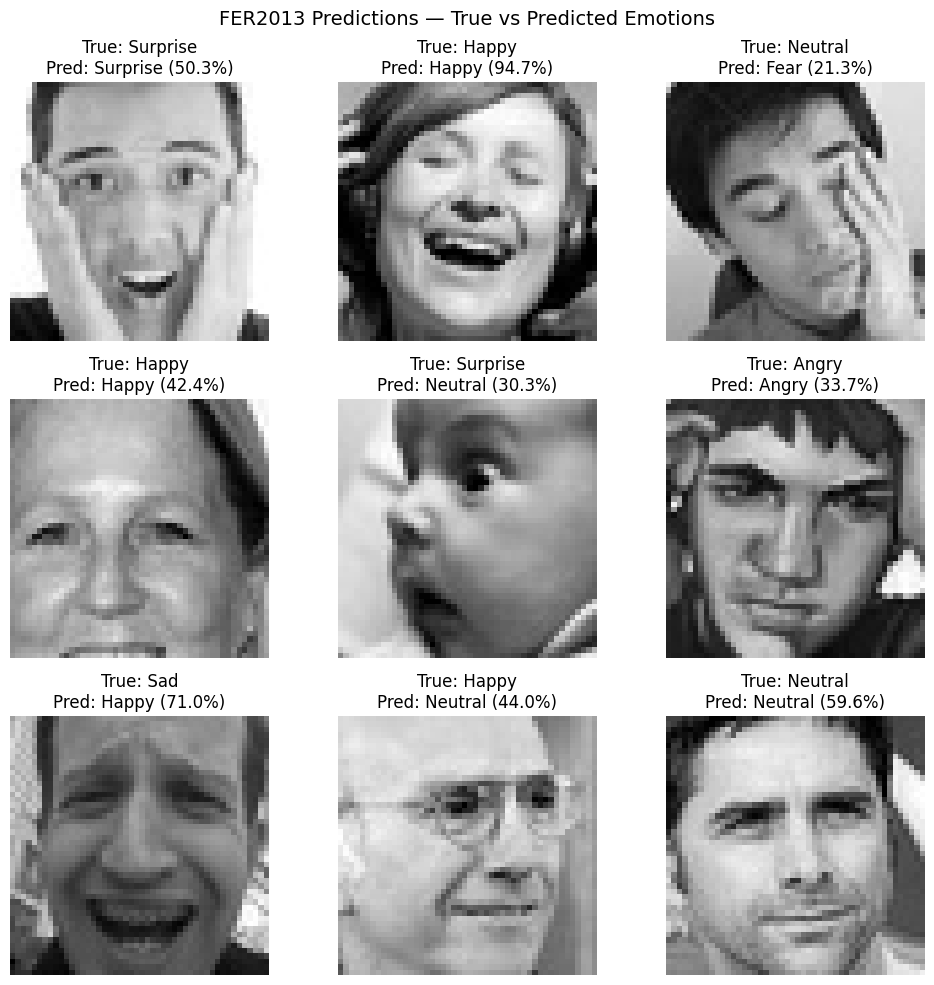

In [98]:
# =============================================================
# Prediction and Visualization (FER2013 Test Samples)
# =============================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# --- Define emotion labels for FER2013 ---
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# --- Use the same validation (test) directory ---
test_dir = "/kaggle/input/fer2013/test"

# --- Create a test dataset (no shuffle, no augmentation) ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=1,
    label_mode='int',
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# --- Select random images for visualization ---
num_images = 9
indices = random.sample(range(len(test_ds)), num_images)
samples = [list(test_ds.skip(i).take(1))[0] for i in indices]

# --- Plot real vs predicted emotions ---
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(samples):
    pred = model.predict(img, verbose=0)
    pred_class = np.argmax(pred)
    confidence = np.max(pred) * 100

    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0].numpy().squeeze(), cmap='gray')
    plt.title(f"True: {emotion_labels[label[0]]}\nPred: {emotion_labels[pred_class]} ({confidence:.1f}%)")
    plt.axis('off')

plt.suptitle("FER2013 Predictions — True vs Predicted Emotions", fontsize=14)
plt.tight_layout()
plt.show()


In [1]:
# =============================================================
# Face Detection and Emotion Prediction (Optimized)
# =============================================================
from google.colab import files
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from google.colab import drive

# Mount Google Drive to access the saved model
drive.mount('/content/drive')

# Define the path to the saved model
model_path = "/content/drive/MyDrive/FER2013_Models/best_model.keras"

# Load trained model (best weights)
try:
    model = keras.models.load_model(model_path)
    print(f"Model loaded successfully from: {model_path}")
except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
    # You might want to add steps here to handle the error,
    # e.g., train the model if not found.


# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# --- Define reusable prediction function ---
@tf.function(reduce_retracing=True)
def predict_face_emotion(face_input):
    """Runs prediction on preprocessed face image"""
    preds = model(face_input, training=False)
    return tf.nn.softmax(preds)

# --- Function to preprocess and predict emotion ---
def predict_emotion(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
        print("No face detected. Try another image.")
        return

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48)) / 255.0
        face_input = np.expand_dims(face_resized, axis=(0, -1))

        # Predict emotion (optimized function)
        # Ensure model is loaded before predicting
        if 'model' in globals() and model is not None:
            preds = predict_face_emotion(tf.convert_to_tensor(face_input, dtype=tf.float32))
            emotion_idx = int(tf.argmax(preds, axis=1))
            confidence = float(tf.reduce_max(preds) * 100)
            predicted_emotion = emotion_labels[emotion_idx]

            # Draw rectangle and label
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img, f"{predicted_emotion} ({confidence:.1f}%)",
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            print(f"Emotion detected: {predicted_emotion}")
            print(f"Confidence: {confidence:.2f}%")
        else:
             print("Model not loaded. Cannot perform prediction.")


    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # Update title to reflect potentially multiple faces or no prediction if model not loaded
    plt.title("Face Detection and Emotion Prediction")
    plt.show()

# --- Upload an image to test ---
uploaded = files.upload()
for fn in uploaded.keys():
    print(f"\nPredicting emotion for: {fn}")
    predict_emotion(fn)

ValueError: mount failed